### This notebook is made to be simplistic so that you can use it as a template when developing your own PPO based controller. The actor and critic networks have 3 inputs, since we have 3 state element. The states are the 2 states from the transfer function $\varphi(s) = G(s)\delta(s)$, as well as the speed v.

In [1]:
import math
import random
import time

import gym
import numpy as np
import scipy.linalg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA on GPU if avaliable</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments to run in parallel</h2>

In [4]:
from Bike_barebone import BikeBareboneEnv # import the custom environment class
from multiprocessing_env import SubprocVecEnv

num_envs = 64

def make_env():
    def _thunk():
        env = BikeBareboneEnv()
        return env

    return _thunk

# Parallel environments used for training:
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

# Single environment used for evaluating:
env = BikeBareboneEnv()

<h2>Neural Network</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        # Critic network:
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        # Actor network:
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        # log-stadard deviation parameter:
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    #clear_output(False)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('update %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
# Calculate cumulative reward for a model:
def test_env(num_steps_eval=int(1e2)):

    state = env.reset()
    done = False
    total_reward = 0
    for i in range(num_steps_eval):
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # convert the current state to torch format
        dist, _ = model(state) # get the distribution for the action from the current RL-agent
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0]) # sample an action from the dist.
        state = next_state
            
        total_reward += reward
        
        if done:
            break
            
    return total_reward


# For a given RL-agent, get the state trajectory from a given state:
def get_state_and_input_sequence(state_0, num_steps_eval = 100):
    state = state_0.copy()
    phi_sequence = [state[0]]
    delta_sequence = []
    v_sequence = [state[2]]
    done = False
    for _ in range(num_steps_eval):
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # convert the state to torch format
        dist, _ = model(state) # get the action distribution
        action = dist.sample().cpu().numpy()[0] # sample an action from the distribution
        next_state, reward, done, _ = env.step(action) # take the action and get the reward and next state
        
        phi_sequence.append(next_state[0])
        delta_sequence.append(action)
        v_sequence.append(next_state[2])
        state = next_state.copy()
        
        if done:
            break
    return phi_sequence, delta_sequence, v_sequence

<h2>Function for calculating the GAE, generalized advantage estimation</h2>

In [7]:
def compute_gae(next_value, rewards, masks, values, gamma=0.999, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [8]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

### Hyperparameters and initiation of model and optimizer:

In [9]:
# The number of state elements is the number of inputs to the neural networks. The size of the state-space
# (or observation space) is fetched from the environment (since we have 4 states it will be 4):
num_inputs  = envs.observation_space.shape[0]
# The output of the actor network is the size of the action space. The size of the state-space
# is fetched from the environment (since delta is the only action it will be 1):
num_outputs = envs.action_space.shape[0]


hidden_size      = 32 # Number of neurons per hidden layer
num_steps_train  = 50 # Length of sequences to train the agent on
num_steps_eval   = 100 # Length of sequences to evaluate the agent on
mini_batch_size  = 64 # The size of the mini batches that the neural network will be trained on. Should not be
                      # larger than num_steps_train*num_envs (=the batch size)
ppo_epochs       = 4 # Number of times the entire batch get passed through the network
gamma = 0.999 # discount factor

# Learning rate
lr = 3e-4

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Load best network.
#### When the training progress has crashed or stagnated: restart the kernel, lower the learning rate and uncomment the model.load_state_dict... You can also change highest_test_reward to the best reward you got, but the only thing it does is that the best performing netowork will not be overwritten if the score is lower than it.

In [10]:
#model.load_state_dict(torch.load('saved_networks/best_network'))
highest_test_reward = -np.inf # Previous highest reward
test_rewards = []

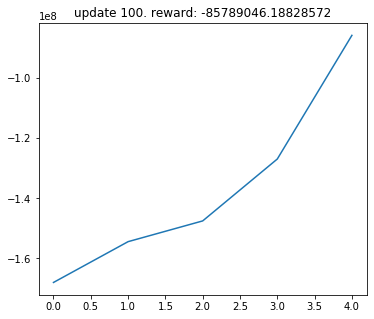

Rewards: [-167973503.88384184, -154405041.86235344, -147506094.44656494, -126922133.40666544, -85789046.18828572]
Current learning rate: 0.0003


KeyboardInterrupt: 

In [11]:
state = envs.reset()
max_ppo_updates = 40000 # Upper limit on how many training updates that can be done
ppo_update_idx  = 0

while ppo_update_idx < max_ppo_updates:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    state = envs.reset()
    
    # Collect sequences from the current agent:
    for _ in range(num_steps_train):
        state = torch.FloatTensor(state).to(device)
        # Get the action distribution and the value for all the state of each paralell environment:
        dist, value = model(state)

        action = dist.sample() # Sample action from the distribution
        next_state, reward, done, _ = envs.step(action.cpu().numpy()) # Take a step with the action

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
              

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values, gamma=gamma)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    # The neural networks are updated here:
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    
    ppo_update_idx += 1
    # Every 20th update, the average cumulative reward is calculated and if it is the hightest as of yet,
    # the best_network will be overwritten
    if ppo_update_idx % 20 == 0:
        test_reward = np.mean([test_env(num_steps_eval = num_steps_eval) for _ in range(64)])
        test_rewards.append(test_reward)
        plot(ppo_update_idx, test_rewards)
        print('Rewards:', test_rewards)
        print('Current learning rate:', lr)
        if test_reward > highest_test_reward:
            torch.save(model.state_dict(), 'saved_networks/best_network')
            highest_test_reward = test_reward
            

### Save and load model

In [13]:
# Save:
#torch.save(model.state_dict(), 'saved_networks/ppo_network')

# Load:
#model.load_state_dict(torch.load('saved_networks/ppo_network'))
#model.load_state_dict(torch.load('saved_networks/ppo_network_almost_report_2x32_0dot999'))


<All keys matched successfully>

### Get average cumulative reward

In [15]:
test_reward = np.mean([test_env() for _ in range(200)])
test_reward

-152580.4477498602

### Plot sequnce

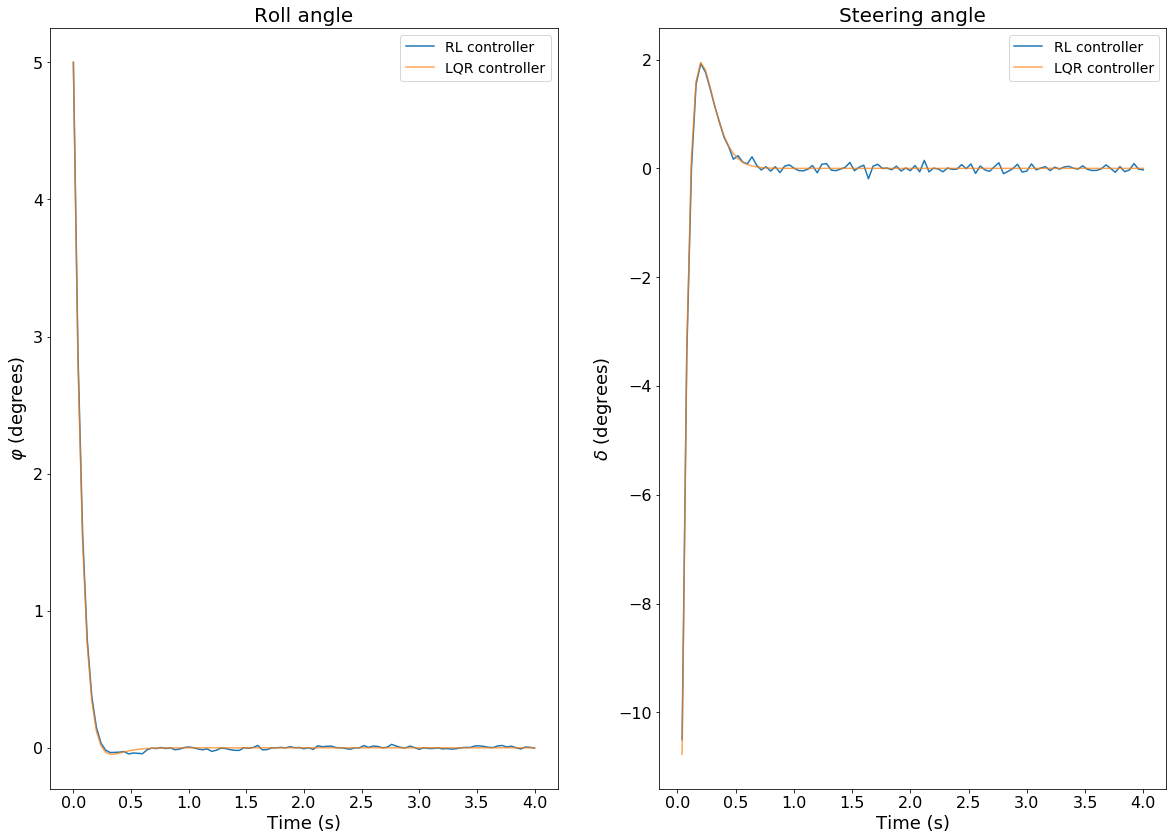

In [14]:
init_phi = np.deg2rad(5)
init_x2 = 0 # non-intuitive state from transfer function
init_v = 5
init_state = np.array([init_phi, init_x2, init_v], dtype=np.float32)

state_0 = env.reset(init_state=init_state)
phi_sequence, delta_sequence, velocity = get_state_and_input_sequence(state_0, num_steps_eval = num_steps_eval)

Ts = 0.04
t = np.arange(0, len(phi_sequence)*Ts, Ts)
fig, axes = plt.subplots(1, 2, figsize=(20,14))

# Roll angle (with RL controller):
axes[0].plot(t, np.rad2deg(phi_sequence), label = "RL controller")
axes[0].set_xlabel('Time (s)', fontsize = 18)
axes[0].set_ylabel(r'$\varphi$ (degrees)', fontsize = 18)
axes[0].set_title('Roll angle', fontsize=20)
axes[0].tick_params(axis="x", labelsize=16)
axes[0].tick_params(axis="y", labelsize=16)

# Steering angle (with RL controller)
axes[1].plot(t[1:], np.rad2deg(delta_sequence), label="RL controller")
axes[1].set_xlabel('Time (s)', fontsize = 18)
axes[1].set_ylabel('$\delta$ (degrees)', fontsize = 18)
axes[1].set_title('Steering angle', fontsize = 20);
axes[1].tick_params(axis="x", labelsize=16)
axes[1].tick_params(axis="y", labelsize=16)


# Plotting the sequences using an LQR as well (they come from using the K gain from the dlqr algorithm)
from utility_functions import get_optimal_sequence
Q = np.array([[1, 0], [0, 0]], dtype=np.float32)
R = 1
optimal_phi_sequence, optimal_delta_sequence = get_optimal_sequence(init_state, env, num_steps_eval)
t_optimal = np.arange(0, len(optimal_phi_sequence)*Ts, Ts)

# Roll angle (with LQR):
axes[0].plot(t_optimal, np.rad2deg(optimal_phi_sequence), alpha=0.7, label = "LQR controller")
axes[0].legend(fontsize=14)
# Steering angle (with LQR):
axes[1].plot(t_optimal[1:], np.rad2deg(optimal_delta_sequence), alpha=0.7, label="LQR controller")
axes[1].legend(fontsize=14);
